## **Problem Statement :**

#### Perform sentimental analysis on the Elon-musk tweets


Import Libraries

In [ ]:
!python -m spacy download en_core_web_trf

In [ ]:
!pip install textblob

In [ ]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import wordcloud
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
lm = WordNetLemmatizer()
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

Import Data

In [4]:
#Import Elon Musk Data
elon = pd.read_csv('/content/Elon_musk.csv',error_bad_lines=False)
elon.head()

,Unnamed: 0,Text
0,1,@kunalb11 I’m an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...


In [5]:
#Import Stop Words
stop_words=pd.read_csv('/content/stop.txt',header=None,)
stop_words=stop_words[0]
stop_words

0               a
1             a's
2            able
3           about
4           above
          ...    
566         yours
567      yourself
568    yourselves
569             z
570          zero
Name: 0, Length: 571, dtype: object

In [6]:
#Import list of positive words. Set the values as 1
positive_words = pd.read_csv('/content/positive-words.txt',header=None)
positive_words['value']=1
positive_words.head()

,0,value
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [7]:
#Import list of negative words. Set the values as -1
negative_words = pd.read_csv('/content/negative-words.txt',header=None)
negative_words['value']=-1
negative_words.head()

,0,value
0,2-faced,-1
1,2-faces,-1
2,abnormal,-1
3,abolish,-1
4,abominable,-1


Data Understanding

In [8]:
elon.shape

(1999, 2)

In [9]:
elon.dtypes

Unnamed: 0     int64
Text          object
dtype: object

In [10]:
elon.isna().sum()

Unnamed: 0    0
Text          0
dtype: int64

In [11]:
elon[elon.duplicated()]

,Unnamed: 0,Text


In [12]:
positive_words.shape

(2006, 2)

In [13]:
negative_words.shape

(4783, 2)

In [14]:
stop_words.shape

(571,)

Data Preparation

In [15]:
#Droping first column
elon=elon.drop('Unnamed: 0',axis=1)
elon.head()

,Text
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


In [16]:
elon=elon.rename({'Text':'Tweets'},axis=1)
elon.head()

,Tweets
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


In [17]:
#Combining both positive and negative words and making it a dictionary.
positive_negative = pd.concat([positive_words,negative_words])
positive_negative_words=positive_negative.set_index(0)['value'].to_dict()
positive_negative_words

{'a+': 1,
 'abound': 1,
 'abounds': 1,
 'abundance': 1,
 'abundant': 1,
 'accessable': 1,
 'accessible': 1,
 'acclaim': 1,
 'acclaimed': 1,
 'acclamation': 1,
 'accolade': 1,
 'accolades': 1,
 'accommodative': 1,
 'accomodative': 1,
 'accomplish': 1,
 'accomplished': 1,
 'accomplishment': 1,
 'accomplishments': 1,
 'accurate': 1,
 'accurately': 1,
 'achievable': 1,
 'achievement': 1,
 'achievements': 1,
 'achievible': 1,
 'acumen': 1,
 'adaptable': 1,
 'adaptive': 1,
 'adequate': 1,
 'adjustable': 1,
 'admirable': 1,
 'admirably': 1,
 'admiration': 1,
 'admire': 1,
 'admirer': 1,
 'admiring': 1,
 'admiringly': 1,
 'adorable': 1,
 'adore': 1,
 'adored': 1,
 'adorer': 1,
 'adoring': 1,
 'adoringly': 1,
 'adroit': 1,
 'adroitly': 1,
 'adulate': 1,
 'adulation': 1,
 'adulatory': 1,
 'advanced': 1,
 'advantage': 1,
 'advantageous': 1,
 'advantageously': 1,
 'advantages': 1,
 'adventuresome': 1,
 'adventurous': 1,
 'advocate': 1,
 'advocated': 1,
 'advocates': 1,
 'affability': 1,
 'affable'

In [18]:
#Word frequency before Removing Stop Words
pd.Series(''.join(elon['Tweets']).split()).value_counts()[0:20]

the        403
to         390
is         345
a          324
of         299
&amp;      216
in         203
for        177
be         153
will       136
@SpaceX    125
on         124
but        109
I          109
that       104
with        99
are         94
at          85
it          83
Tesla       78
dtype: int64

In [19]:
def clean_tweets(tweets):
  """Make the text lowercase, remove text in square brackets, punctuations and special characters 
  """
  tweets=tweets.lower()
  tweets=re.sub('\[.*?\]',' ',tweets)
  tweets=re.sub('[%s]'%re.escape(string.punctuation),' ',tweets)
  tweets=re.sub('\w*\d\w*',' ',tweets)
  tweets = re.sub("[0-9" "]+"," ",tweets)
  tweets = re.sub('[‘’“”…]', '', tweets)
  tweets=re.sub('https:\ $',' ',tweets)
  tweets=re.sub('http',' ',tweets)
  tweets=re.sub(" _'_ ",' ',tweets)
  tweets=tweets.split()
  tweets=[lm.lemmatize(word) for word in tweets if word not in stop_words.values]
  tweets=' '.join(tweets)
  return tweets

clean = lambda x: clean_tweets(x)

In [20]:
elon['Tweets']=elon['Tweets'].apply(clean)
elon.head()

,Tweets
0,im alien
1,id aa carmack ray tracing cyberpunk hdr level
2,joerogan spotify great interview
3,doge underestimated
4,teslacn congratulation tesla china amazing exe...


In [21]:
#Word frequency After Removing Stop Words
pd.Series(''.join(elon['Tweets']).split()).value_counts()[0:20]

amp                211
spacex             204
tesla              145
great               55
launch              50
erdayastronaut      50
space               48
good                41
make                38
dragon              37
nasa                36
nasaspaceflight     34
high                32
engine              32
ppathole            32
yeah                31
flcnhvy             31
aa                  31
crew                31
year                30
dtype: int64

In [22]:
#Get the subjectivity and Polarity
def sentimental_analysis(elon):
  senti=TextBlob(elon['Tweets']).sentiment
  return pd.Series([senti.subjectivity,senti.polarity])

elon[['Subjectivity','Polarity']] = elon.apply(sentimental_analysis,axis=1)
elon.head()

,Tweets,Subjectivity,Polarity
0,im alien,0.75,-0.25
1,id aa carmack ray tracing cyberpunk hdr level,0.00,0.00
2,joerogan spotify great interview,0.75,0.80
3,doge underestimated,0.00,0.00
4,teslacn congratulation tesla china amazing exe...,0.90,0.60


In [23]:
def analysis(score):
  if score<0:
    return 'Negative'
  elif score==0:
    return 'Neutral'
  else:
    return 'Positive'

elon['Analysis']= elon['Polarity'].apply(analysis)
elon.head()

,Tweets,Subjectivity,Polarity,Analysis
0,im alien,0.75,-0.25,Negative
1,id aa carmack ray tracing cyberpunk hdr level,0.00,0.00,Neutral
2,joerogan spotify great interview,0.75,0.80,Positive
3,doge underestimated,0.00,0.00,Neutral
4,teslacn congratulation tesla china amazing exe...,0.90,0.60,Positive


In [24]:
vect=CountVectorizer(min_df=1,max_df=0.8)
X = vect.fit_transform(elon['Tweets'])
vect_df=pd.DataFrame()
vect_df['Term']=vect.get_feature_names_out()
vect_df['Occurence']=np.asarray(X.sum(axis=0)).ravel().tolist()
vect_df['Frequency']=vect_df['Occurence']/np.sum(vect_df['Occurence'])
vect_df.sort_values(by='Occurence')

,Term,Occurence,Frequency
1993,living,1,0.000084
2329,noch,1,0.000084
2330,noise,1,0.000084
2332,nonchalant,1,0.000084
2334,norris,1,0.000084
...,...,...,...
2942,rt,127,0.010706
1112,erdayastronaut,142,0.011970
3457,tesla,179,0.015089
133,amp,219,0.018461


In [25]:
vect_tfid=TfidfVectorizer(max_features=1000,max_df=0.5,stop_words='english',smooth_idf=True)
Y=vect_tfid.fit_transform(elon['Tweets'])
features=vect_tfid.get_feature_names_out()
vect_tfid_df=pd.DataFrame(Y.todense().tolist(),columns=features)
vect_tfid_df.head()

,aa,abort,absolutely,acceptable,access,accurate,actual,adamklotz,add,adding,...,youd,youranonnews,youre,yourfavgas,youve,ystijd,yup,zero,zimon,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.401048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
vect_tfid_df.shape

(1999, 1000)

N - Grams

Bi-Gram

In [27]:
def get_top_n_words(df,n=None,ngram=None):
  vect_bigrams=CountVectorizer(max_features=2000,ngram_range=ngram).fit(df)
  bag_of_words=vect_bigrams.transform(df)
  sum_of_words=bag_of_words.sum(axis=0)
  word_frequency=[(word,sum_of_words[0,idx]) for word,idx in vect_bigrams.vocabulary_.items()]
  word_frequency=sorted(word_frequency,key=lambda x : x[1],reverse=True)
  return word_frequency[:n]

In [28]:
top_2=get_top_n_words(elon['Tweets'],n=200,ngram=(2,2))
top_2_df=pd.DataFrame(top_2,columns=['bi-gram','frequency'])
top_2_df.head()

,bi-gram,frequency
0,rt spacex,71
1,id aa,31
2,aa carmack,31
3,space station,31
4,engineer feed,30


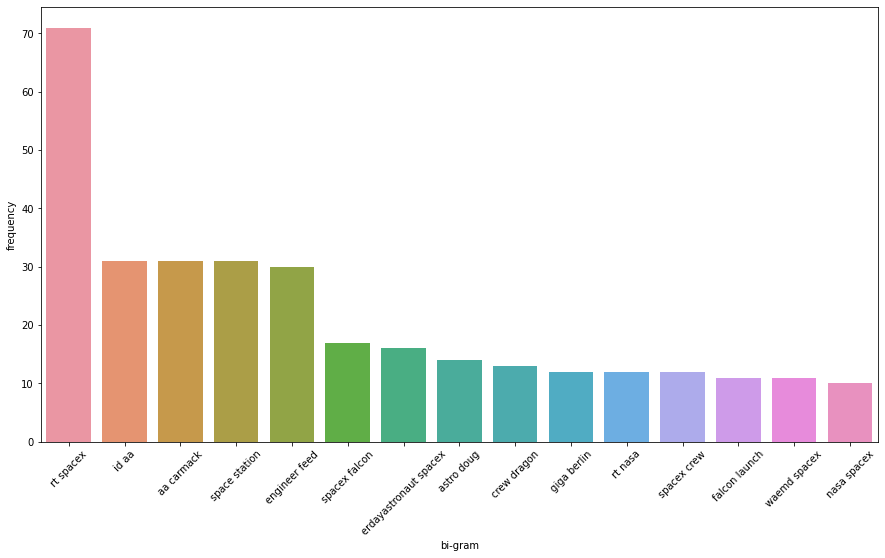

In [29]:
top_15_bigram = top_2_df.iloc[0:15,:]
plt.figure(figsize=(15,8))
fig=sns.barplot(top_15_bigram['bi-gram'],top_15_bigram['frequency'])
fig.set_xticklabels(rotation=45,labels=top_15_bigram['bi-gram'])
plt.show()

Tri-Gram

In [30]:
top_3=get_top_n_words(elon['Tweets'],n=200,ngram=(3,3))
top_3_df=pd.DataFrame(top_3,columns=['Tri-gram','frequency'])
top_3_df.head()

,Tri-gram,frequency
0,id aa carmack,31
1,rt spacex falcon,17
2,spacex falcon stage,8
3,thesheetztweetz waemd spacex,8
4,astrobehnken astro doug,8


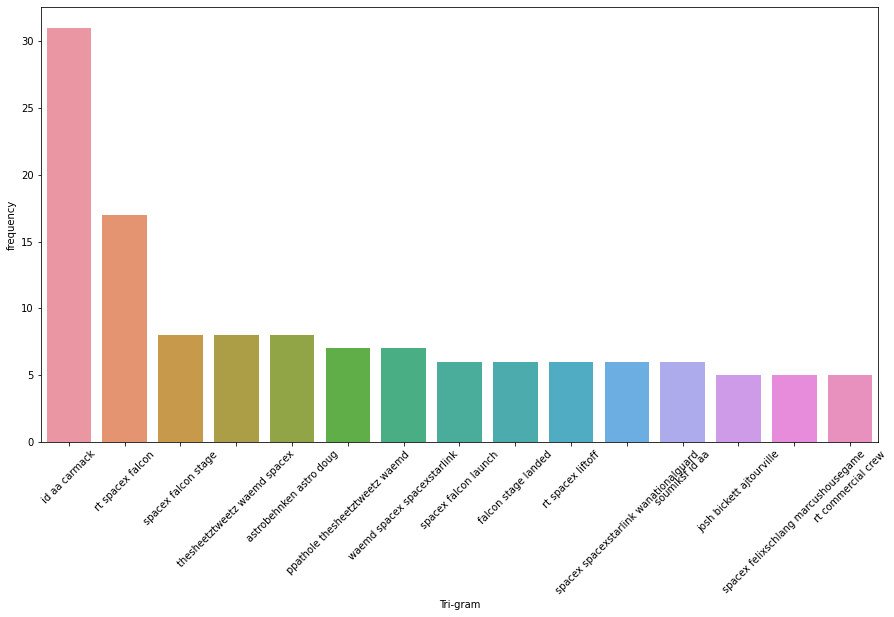

In [31]:
top_15_trigram = top_3_df.iloc[0:15,:]
plt.figure(figsize=(15,8))
fig=sns.barplot(top_15_trigram['Tri-gram'],top_15_trigram['frequency'])
fig.set_xticklabels(rotation=45,labels=top_15_trigram['Tri-gram'])
plt.show()

Word Cloud

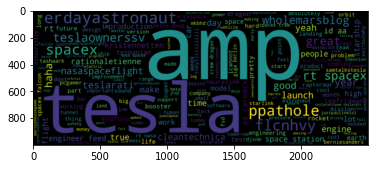

In [32]:
#From complete tweets
string = " ".join(elon['Tweets'])
word_cloud = WordCloud(width=2500,height=1000).generate(string)
plt.imshow(word_cloud,interpolation='bilinear')
plt.show()

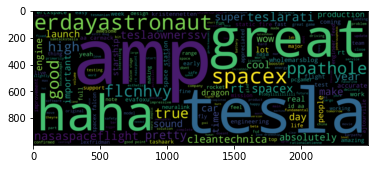

In [33]:
#From Positive Tweets
string_positive = " ".join(elon[elon['Analysis']=='Positive']['Tweets'])
word_cloud_positive = WordCloud(width=2500,height=1000).generate(string_positive)
plt.imshow(word_cloud_positive,interpolation='bilinear')
plt.show()

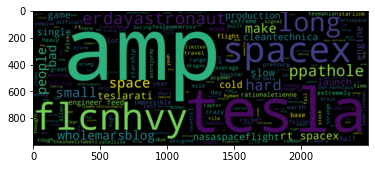

In [34]:
#From Negative Tweets
string_negative = " ".join(elon[elon['Analysis']=='Negative']['Tweets'])
word_cloud_negative = WordCloud(width=2500,height=1000).generate(string_negative)
plt.imshow(word_cloud_negative,interpolation='bilinear')
plt.show()

In [35]:
len(string_positive)/len(negative_words)

7.296257578925361

In [36]:
nlp=spacy.load('en_core_web_trf')

Calculate Sentiment Score

In [37]:
def calculate_sentiment(text: str=None):
  """This function gets the input string, Use pretrained model "en_core_web_trf" to preprocess the input string,
     Assign each word a sentiment value (+1 for positive words, -1 for negative words) sum it up for each sentence
     and return the sum value.
  """
  senti_score = 0
  if text:
    sentence = nlp(text)
    for word in sentence:
      senti_score = senti_score + positive_negative_words.get(word.lemma_,0)
  return senti_score

In [38]:
calculate_sentiment('happy')    #Validate Sentiment score for an example string - 'happy' which returns 1 (positive word)

1

In [39]:
elon['sentiment_score']=elon['Tweets'].apply(calculate_sentiment) #new column sentiment score, apply calculate_sentiment function to each sentence.

In [40]:
elon.head()

,Tweets,Subjectivity,Polarity,Analysis,sentiment_score
0,im alien,0.75,-0.25,Negative,0
1,id aa carmack ray tracing cyberpunk hdr level,0.00,0.00,Neutral,0
2,joerogan spotify great interview,0.75,0.80,Positive,1
3,doge underestimated,0.00,0.00,Neutral,-1
4,teslacn congratulation tesla china amazing exe...,0.90,0.60,Positive,2


In [41]:
elon['Word Count']= elon['Tweets'].str.split().apply(len)
elon.head()

,Tweets,Subjectivity,Polarity,Analysis,sentiment_score,Word Count
0,im alien,0.75,-0.25,Negative,0,2
1,id aa carmack ray tracing cyberpunk hdr level,0.00,0.00,Neutral,0,8
2,joerogan spotify great interview,0.75,0.80,Positive,1,4
3,doge underestimated,0.00,0.00,Neutral,-1,2
4,teslacn congratulation tesla china amazing exe...,0.90,0.60,Positive,2,7


Model Analysis and Visualization

In [42]:
elon.sort_values(by='sentiment_score').tail(10)

,Tweets,Subjectivity,Polarity,Analysis,sentiment_score,Word Count
468,picot john cyberpunkgame good great game imo i...,0.562500,0.150000,Positive,3,12
1330,disruptresearch tesla amp productivity excepti...,0.487500,0.287500,Positive,3,10
1427,ajtourville im fine reasonable drone footage f...,0.666667,0.438889,Positive,3,10
1515,krystof mitka biindia winning worst person ive...,0.720833,0.033333,Positive,3,13
1590,teslarati rate improvement original gpt gpt im...,0.875000,0.687500,Positive,3,9
1097,kristennetten flcnhvy favorite writer foundati...,0.927083,0.152778,Positive,3,10
1172,tesla team great work delivery owner super acc...,0.708333,0.566667,Positive,3,11
1357,great trip germany support government amp peop...,0.505556,0.444444,Positive,4,9
1388,gerberkawasaki wow super loved astronomy queen...,0.866667,0.408333,Positive,4,9
1304,excitement guaranteed support greater boca pad...,0.300000,0.350000,Positive,5,9


In [43]:
elon.sentiment_score.describe()

count    1999.000000
mean        0.123562
std         0.821532
min        -4.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: sentiment_score, dtype: float64

In [44]:
elon[elon['sentiment_score']<=-4].head()['Tweets'].to_list()[0]

'physic impossible trivial impossible understand trivial rutherford'

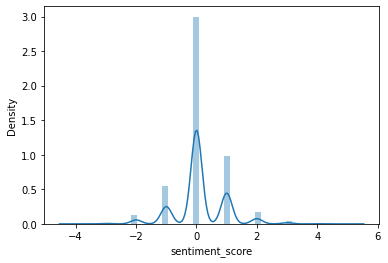

In [45]:
sns.distplot(elon.sentiment_score)
plt.show()

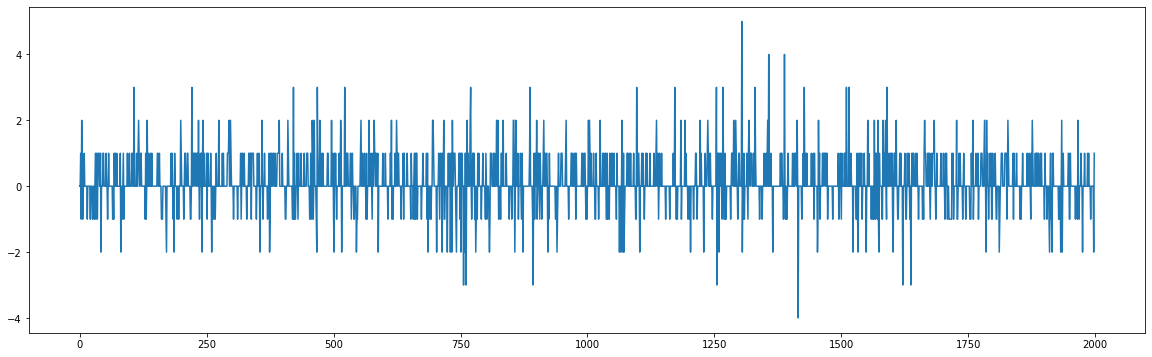

In [46]:
elon.sentiment_score.plot(figsize=(20,6))
plt.show()

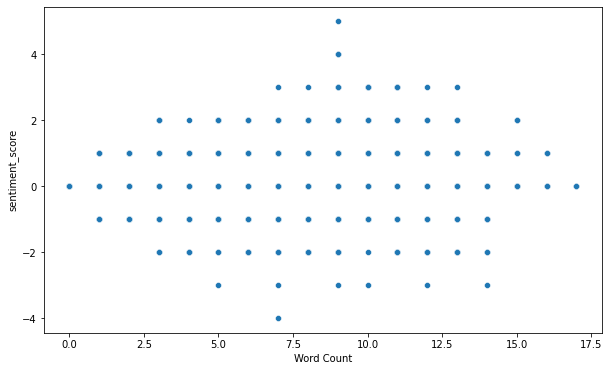

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=elon,x='Word Count',y='sentiment_score')
plt.show()

End !!!